This script is used to plot figures for my chapter 1.  These scripts exist elsewhere, but I want a way to plot nicely standardized.

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import math
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# paths to various directories
rda_era5_path = '/glade/campaign/collections/rda/data/ds633.0/'  # base path to ERA5 data on derecho
my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions

# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data, time_to_year_month_avg, time_to_year_month_sum, time_to_year_month
from my_functions import month_num_to_name, ensure_var_list

# import lists and dictionaries
from my_dictionaries import (
sfc_instan_list, sfc_accumu_list, pl_var_list, derived_var_list, invar_var_list,
NAM_var_list, region_avg_list, flux_var_list, vector_var_list, misc_var_list,
var_dict, var_units, region_avg_dict, region_avg_coords, region_colors_dict
)

In [46]:
# define a function to plot the boundaries for the domains
def plot_domain(save_png=False, out_fp=None, dpi=1000):
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-130, -90, 10, 50], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, color='lightgreen', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
    # ax.set_facecolor('lightgreen')
    
    # coords for regions: [west, east, north, south]
    region_coords = {
        'NAM': [240, 260, 42, 20],  # North American Monsoon Influence Region
        'dsw': [245, 257, 39, 27],  # Desert Southwest Region
        'cp': [249, 253, 39, 35],  # Colorado Plateau Region
    }
    region_colors = {
        'NAM': 'black',
        'dsw': 'brown',
        'cp': 'blue'
    }

    # plot regions
    for region, coords in region_coords.items():
        lon = [coords[0], coords[1], coords[1], coords[0], coords[0]]
        lat = [coords[2], coords[2], coords[3], coords[3], coords[2]]
        ax.plot(lon, lat, color=region_colors[region], linewidth=3, transform=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = True
    gl.right_labels = True
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = plt.FixedLocator(range(-130, -89, 5))
    gl.ylocator = plt.FixedLocator(range(10, 51, 5))

    plt.tight_layout()
    if save_png:
        plt.savefig(f'{out_fp}', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close('all')

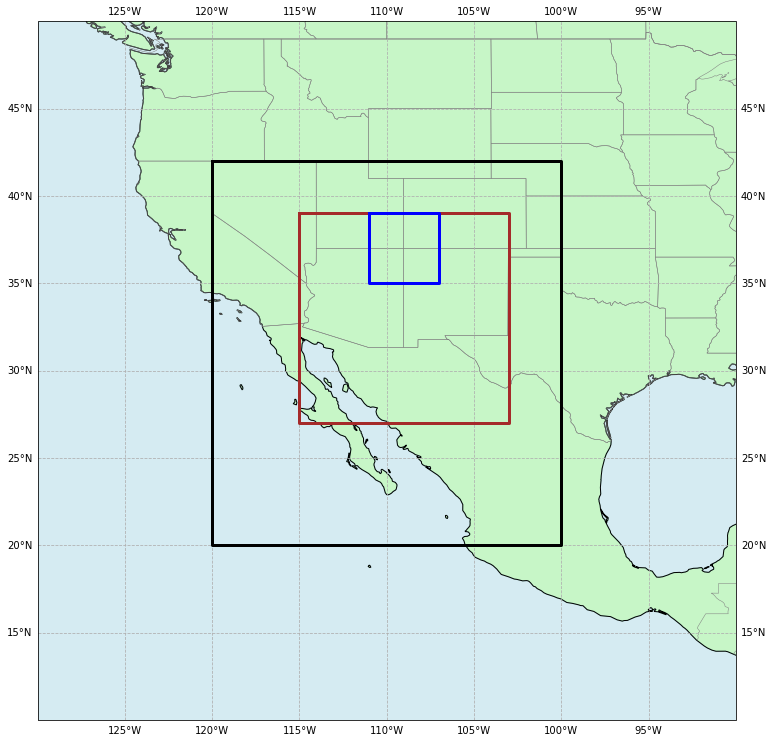

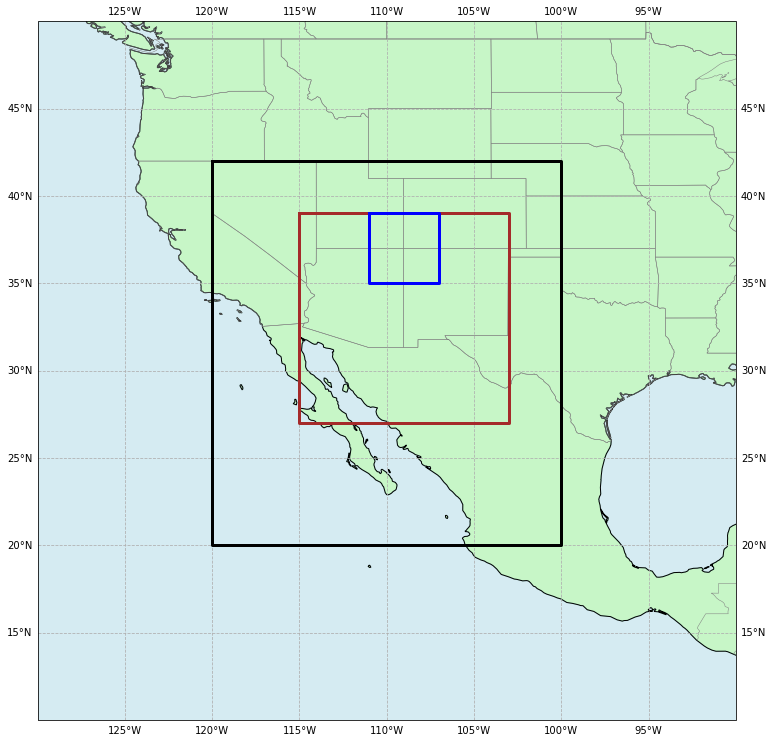

In [50]:
if __name__ == '__main__':
    base_fp = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/chapter_1/'
    out_fn = 'domains.png'

    save_png = False
    out_fp_list = [os.path.join(base_fp, 'low_res', out_fn), os.path.join(base_fp, 'high_res', out_fn)]
    dpi_list = [300, 1000]

    for out_fp, dpi in zip(out_fp_list, dpi_list):
        plot_domain(save_png, out_fp, dpi)

In [13]:
# define a function to plot the mean onset and length of the NAM
def plot_onset_length(save_png=False, out_fp=None, dpi=1000, **kwargs):
    # get data
    onset = get_var_data('onset').mean('year', skipna=True)
    length = get_var_data('length').mean('year', skipna=True)

    # get spatial correlation
    x = -1 * onset.stack(space=('latitude', 'longitude')).values  # * -1 to flip positive direction
    y = length.stack(space=('latitude', 'longitude')).values
    rval, pval = sp.stats.pearsonr(x, y)

    # set contour levels
    # vmin = onset.min(skipna=True).compute().values.round().astype(int)
    # vmax = onset.max(skipna=True).compute().values.round().astype(int)
    vmin = pd.to_datetime(['2001-05-01']).dayofyear.values
    vmax = pd.to_datetime(['2001-08-01']).dayofyear.values
    cf_levels = np.arange(vmin, vmax+1)
    norm = plt.Normalize(vmin, vmax)
    cs_levels = [i for i in np.arange(30, 151, 15)]

    # define a custom colormap
    colors = [
        (1.0, 0.0, 0.0),  # red
        (1.0, 0.5, 0.0),  # orange
        (1.0, 1.0, 0.0),  # yellow
        (0.0, 1.0, 1.0),  # cyan
        (0.0, 0.0, 1.0),  # blue
    ]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # make figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

    cf = ax.contourf(onset.longitude, onset.latitude, onset, levels=cf_levels,
                     cmap=custom_cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

    cs = ax.contour(length.longitude, length.latitude, length, levels=cs_levels,
                    linewidths=1, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # # add colorbar and ticks
    # cbar = plt.colorbar(cf, ax=ax, pad=0.02)
    # datetimes = pd.to_datetime(['2001-05-01', '2001-05-15', '2001-06-01', '2001-06-15', '2001-07-01', '2001-07-15', '2001-08-01'])
    # ticks = datetimes.dayofyear.values  # day of the year
    # tick_labels = datetimes.strftime('%d %b').values  # day month
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels(tick_labels)
    # cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter(tick_labels))           
    # c_label = plt.clabel(cs, inline=True, fontsize=12, fmt='%.0f')

    plt.tight_layout()
    if save_png:
        plt.savefig(out_fp, dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f'r-value: {rval}, p-value: {pval}')


# define a function to plot the color bar for the onset/length
def plot_onset_length_colorbar(save_png_cbar, out_fp_cbar, dpi_cbar, **kwargs):
    vmin = pd.to_datetime(['2001-05-01']).dayofyear.values
    vmax = pd.to_datetime(['2001-08-01']).dayofyear.values
    
    fig, ax = plt.subplots(figsize=(10, 0.5))  # adjust figsize
    # define a custom colormap
    colors = [
        (1.0, 0.0, 0.0),  # red
        (1.0, 0.5, 0.0),  # orange
        (1.0, 1.0, 0.0),  # yellow
        (0.0, 1.0, 1.0),  # cyan
        (0.0, 0.0, 1.0),  # blue
    ]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap),
                        orientation=kwargs.get('cbar_orientation', 'horizontal'), ax=ax, pad=0.02,
                        fraction=1, extend='both')
    datetimes = pd.to_datetime(['2001-05-01', '2001-05-15', '2001-06-01', '2001-06-15', '2001-07-01', '2001-07-15', '2001-08-01'])
    ticks = datetimes.dayofyear.values  # day of the year
    tick_labels = datetimes.strftime('%d %b').values  # day month
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter(tick_labels))    
    plt.axis('off')  # turn off axis
    # plt.tight_layout()

    # save color bar as an image
    if save_png_cbar:
        plt.savefig(out_fp_cbar, dpi=dpi_cbar, bbox_inches='tight')
    plt.show()
    plt.close()

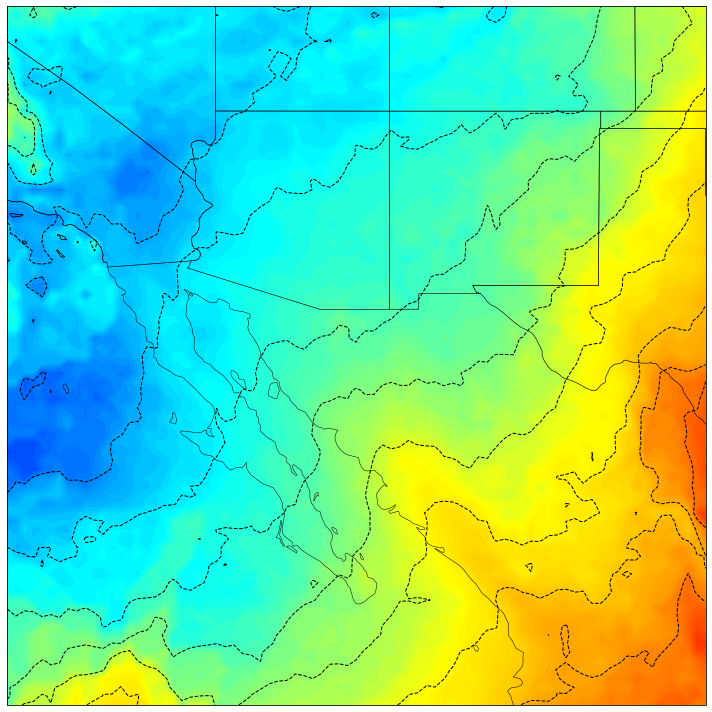

r-value: 0.9024320412948728, p-value: 0.0


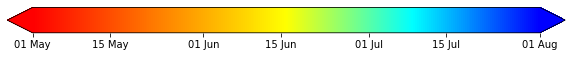

In [11]:
if __name__ == '__main__':
    base_fp = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/chapter_1/'
    
    out_fn = 'onset_length.png'
    save_png = False
    dpi = 300
    res_path = 'low_res' if dpi < 500 else 'high_res'
    out_fp = os.path.join(base_fp, res_path, out_fn)
    
    plot_onset_length(save_png, out_fp, dpi)

    out_fn_cbar = 'onset_length_cbar.png'
    save_png_cbar = False if save_png == False else True
    dpi_cbar = 300
    res_path_cbar = 'low_res' if dpi_cbar < 500 else 'high_res'
    out_fp_cbar = os.path.join(base_fp, res_path_cbar, out_fn_cbar)
    
    plot_onset_length_colorbar(save_png_cbar, out_fp_cbar, dpi_cbar)

In [22]:
def plot_heights(month, save_png=False, out_fp=None, dpi=1000):
    # get data
    z_height = get_var_data('z_height', level=500)
    z_mean = z_height.resample(time='1M').mean('time', skipna=True).groupby('time.month').mean('time', skipna=True)

    # set contour levels
    vmin = 5790 if month == 6 else 5860
    vmax = 5890 if month == 6 else 5920
    cf_levels = np.arange(vmin, vmax+1, 1)
    norm = plt.Normalize(vmin, vmax)
    cs_levels = 10

    # make figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

    cf = ax.contourf(z_mean.sel(month=month).longitude, z_mean.sel(month=month).latitude, z_mean.sel(month=month),
                     levels=cf_levels, cmap='turbo', norm=norm, extend='both', transform=ccrs.PlateCarree())

    cs = ax.contour(z_mean.sel(month=month).longitude, z_mean.sel(month=month).latitude, z_mean.sel(month=month),
                    levels=cs_levels, linewidths=0.5, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # # add colorbar and ticks
    # cbar = plt.colorbar(cf, ax=ax, label='meters', pad=0.02)
    # if month == 6:
    #     ticks = np.arange(vmin, vmax+10, 10)
    # else:
    #     ticks = np.arange(vmin, vmax+5, 5)
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([str(i) for i in ticks])
    # cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter([str(i) for i in ticks]))           
    c_label = plt.clabel(cs, inline=True, fontsize=8, fmt='%.0f')

    plt.tight_layout()
    if save_png:
        plt.savefig(out_fp, dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()


# define a function to plot the color bar for the heights
def plot_heights_colorbar(month, save_png_cbar, out_fp_cbar, dpi_cbar, **kwargs):
    vmin = 5790 if month == 6 else 5860
    vmax = 5890 if month == 6 else 5920
    
    fig, ax = plt.subplots(figsize=(10, 0.5))  # adjust figsize
    # define a custom colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='turbo'),
                        orientation=kwargs.get('cbar_orientation', 'horizontal'), ax=ax, pad=0.02,
                        fraction=1, extend='both', label='meters')
    tick_interval = 10 if month ==6 else 5
    ticks = np.arange(vmin, vmax + tick_interval, tick_interval)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(i) for i in ticks])
    cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter([str(i) for i in ticks]))   
    plt.axis('off')  # turn off axis
    # plt.tight_layout()

    # save color bar as an image
    if save_png_cbar:
        plt.savefig(out_fp_cbar, dpi=dpi_cbar, bbox_inches='tight')
    plt.show()
    plt.close()

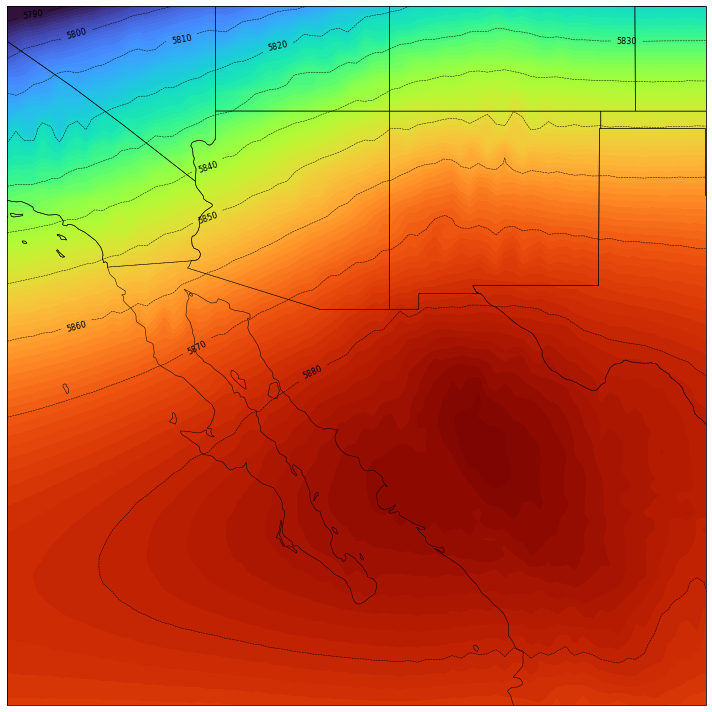

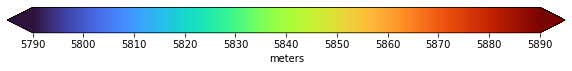

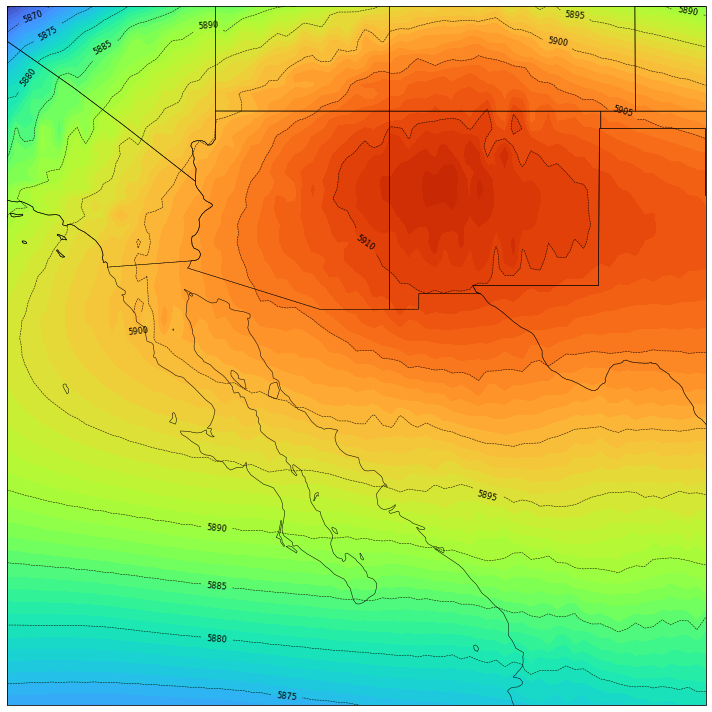

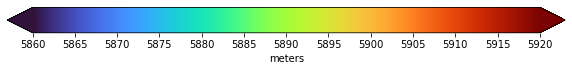

In [26]:
if __name__ == '__main__':
    base_fp = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/chapter_1/'
    out_fn_list = ['z_height_500_June.png', 'z_height_500_July.png']
    out_fn_cbar_list = ['z_height_500_June_cbar.png', 'z_height_500_July_cbar.png']

    for month, out_fn, out_fn_cbar in zip([6, 7], out_fn_list, out_fn_cbar_list):
        save_png = False
        dpi = 300
        res_path = 'low_res' if dpi < 500 else 'high_res'
        out_fp = os.path.join(base_fp, res_path, out_fn)

        plot_heights(month, save_png, out_fp, dpi)

        
        save_png_cbar = False if save_png == False else True
        dpi_cbar = 300
        res_path_cbar = 'low_res' if dpi_cbar < 500 else 'high_res'
        out_fp_cbar = os.path.join(base_fp, res_path_cbar, out_fn_cbar)
        
        plot_heights_colorbar(month, save_png_cbar, out_fp_cbar, dpi_cbar)
        

In [24]:
# define a function to plot the geopotential heights for the 10 earliest and 10 latest onsets
def plot_max_min_heights(month, years, save_png=False, out_fp=None, dpi=1000):
    # get data
    z_height = get_var_data('z_height', level=500)
    z_years = z_height.sel(time=(z_height['time.year'].isin(years) & z_height['time.month'].isin(month)))
    z_mean = z_years.mean('time', skipna=True)

    # set contour levels
    vmin = 5790 if month == 6 else 5860
    vmax = 5890 if month == 6 else 5920
    cf_levels = np.arange(vmin, vmax+1, 1)
    norm = plt.Normalize(vmin, vmax)
    cs_levels = 10

    # make figure
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

    cf = ax.contourf(z_mean.longitude, z_mean.latitude, z_mean,
                     levels=cf_levels, cmap='turbo', norm=norm, extend='both', transform=ccrs.PlateCarree())

    cs = ax.contour(z_mean.longitude, z_mean.latitude, z_mean,
                    levels=cs_levels, linewidths=0.5, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # # add colorbar and ticks
    # cbar = plt.colorbar(cf, ax=ax, label='meters', pad=0.02)
    # if month == 6:
    #     ticks = np.arange(vmin, vmax+10, 10)
    # else:
    #     ticks = np.arange(vmin, vmax+5, 5)
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([str(i) for i in ticks])
    # cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter([str(i) for i in ticks]))           
    c_label = plt.clabel(cs, inline=True, fontsize=8, fmt='%.0f')

    plt.tight_layout()
    if save_png:
        plt.savefig(out_fp, dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()


# define a function to plot the color bar for the max/min heights
def plot_max_min_heights_colorbar(month, save_png_cbar, out_fp_cbar, dpi_cbar, **kwargs):
    vmin = 5790 if month == 6 else 5860
    vmax = 5890 if month == 6 else 5920
    
    fig, ax = plt.subplots(figsize=(10, 0.5))  # adjust figsize
    # define a custom colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='turbo'),
                        orientation=kwargs.get('cbar_orientation', 'horizontal'), ax=ax, pad=0.02,
                        fraction=1, extend='both', label='meters')
    tick_interval = 10 if month ==6 else 5
    ticks = np.arange(vmin, vmax + tick_interval, tick_interval)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(i) for i in ticks])
    cbar.ax.yaxis.set_major_formatter(ticker.FixedFormatter([str(i) for i in ticks]))   
    plt.axis('off')  # turn off axis
    # plt.tight_layout()

    # save color bar as an image
    if save_png_cbar:
        plt.savefig(out_fp_cbar, dpi=dpi_cbar, bbox_inches='tight')
    plt.show()
    plt.close()

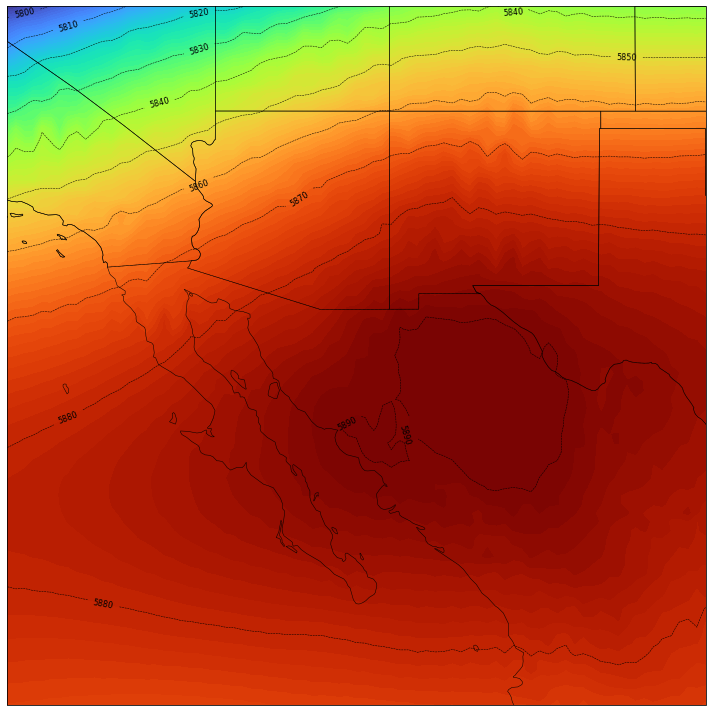

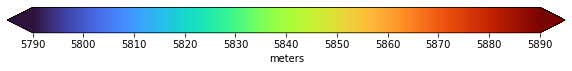

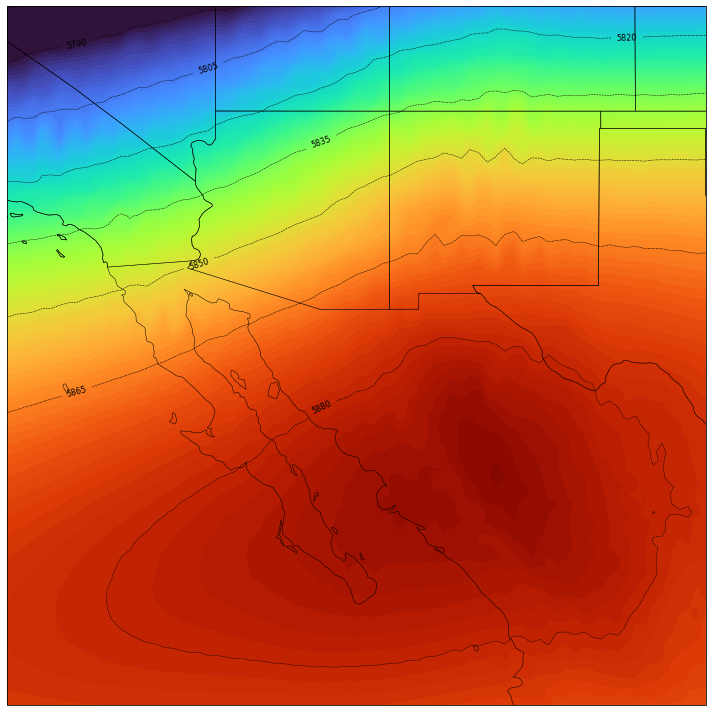

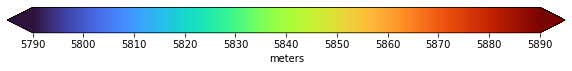

In [31]:
if __name__ == '__main__':
    # max and min years for longest NAM
    max_years = [2015, 1984, 1990, 1986, 2018, 1981, 1983, 1994, 1980, 2016]
    min_years = [2006, 2008, 1997, 1993, 1995, 2011, 1989, 2005, 1987, 2004]
    ranked_years = [max_years, min_years]

    base_fp = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/chapter_1/'
    out_fn_list = ['z_height_500_June_max_length.png', 'z_height_500_June_min_length.png']
    out_fn_cbar_list = ['z_height_500_June_max_length_cbar.png', 'z_height_500_June_min_length_cbar.png']

    for i, (out_fn, out_fn_cbar) in enumerate(zip(out_fn_list, out_fn_cbar_list)):
        save_png = False
        dpi = 300
        res_path = 'low_res' if dpi < 500 else 'high_res'
        out_fp = os.path.join(base_fp, res_path, out_fn)
        
        plot_max_min_heights(6, ranked_years[i], save_png, out_fp, dpi)

        save_png_cbar = False if save_png == False else True
        dpi_cbar = 300
        res_path_cbar = 'low_res' if dpi_cbar < 500 else 'high_res'
        out_fp_cbar = os.path.join(base_fp, res_path_cbar, out_fn_cbar)
        
        plot_max_min_heights_colorbar(6, save_png_cbar, out_fp_cbar, dpi_cbar)

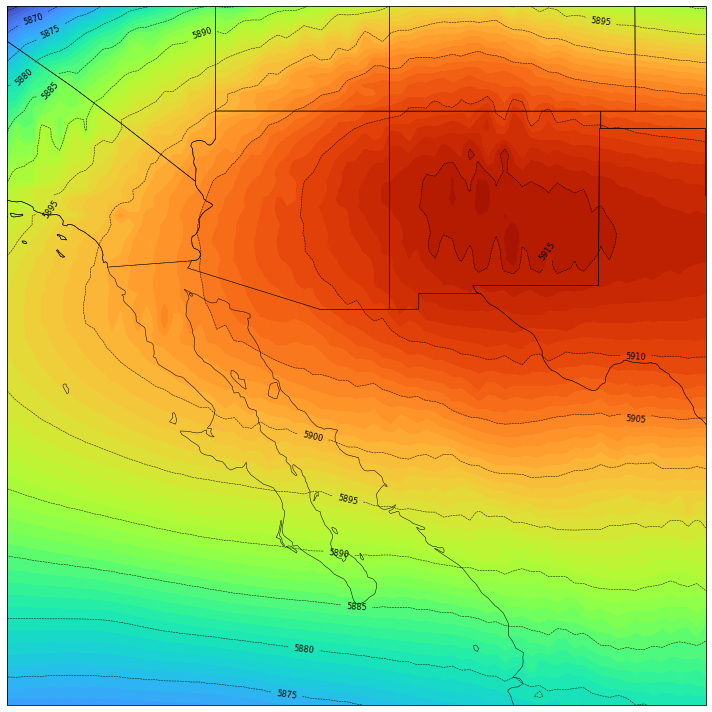

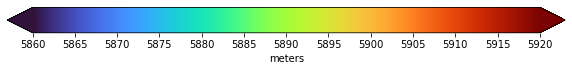

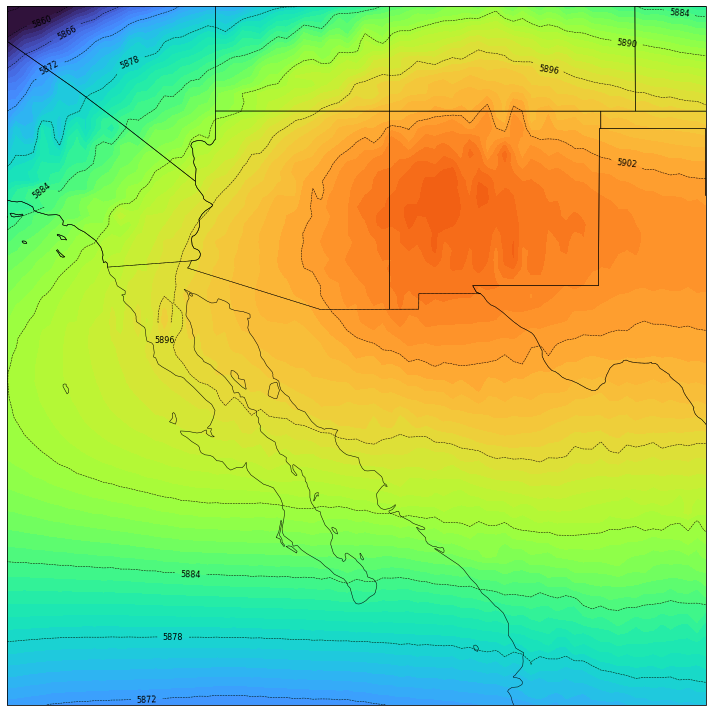

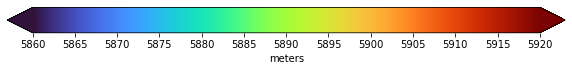

In [32]:
if __name__ == '__main__':
    # max and min years for longest NAM
    max_years = [2015, 1984, 1990, 1986, 2018, 1981, 1983, 1994, 1980, 2016]
    min_years = [2006, 2008, 1997, 1993, 1995, 2011, 1989, 2005, 1987, 2004]
    ranked_years = [max_years, min_years]

    base_fp = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/figures/chapter_1/'
    out_fn_list = ['z_height_500_July_max_length.png', 'z_height_500_July_min_length.png']
    out_fn_cbar_list = ['z_height_500_July_max_length_cbar.png', 'z_height_500_July_min_length_cbar.png']

    for i, (out_fn, out_fn_cbar) in enumerate(zip(out_fn_list, out_fn_cbar_list)):
        save_png = True
        dpi = 300
        res_path = 'low_res' if dpi < 500 else 'high_res'
        out_fp = os.path.join(base_fp, res_path, out_fn)
        
        plot_max_min_heights(7, ranked_years[i], save_png, out_fp, dpi)

        save_png_cbar = False if save_png == False else True
        dpi_cbar = 300
        res_path_cbar = 'low_res' if dpi_cbar < 500 else 'high_res'
        out_fp_cbar = os.path.join(base_fp, res_path_cbar, out_fn_cbar)
        
        plot_max_min_heights_colorbar(7, save_png_cbar, out_fp_cbar, dpi_cbar)